## Lab 01. Poetry generation

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [20]:
import string
import os
import itertools
from IPython.display import clear_output

import matplotlib.pyplot as plt
from random import sample
import random
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [4]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/girafe-ai/ml-mipt/master/homeworks_basic/Lab2_DL/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [11]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here
text = "".join(text).lower()
assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


### Data loading: "Евгений Онегин"


In [3]:
!wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
    
with open('onegin.txt', 'r') as iofile:
    text = iofile.readlines()
    
text = [x.replace('\t\t', '') for x in text]

--2020-05-10 19:02:32--  https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.244.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.244.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262521 (256K) [text/plain]
Saving to: ‘onegin.txt’

onegin.txt          100%[===================>] 256.37K  --.-KB/s    in 0.1s    

2020-05-10 19:02:33 (2.25 MB/s) - ‘onegin.txt’ saved [262521/262521]



In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [14]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here

out = set(text)

Put all the characters, that you've seen in the text, into variable `tokens`.

In [22]:
tokens = sorted(set(out))
num_tokens = len(tokens)

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [23]:
# dict <index>:<char>
# Your great code here
token_to_idx = {char: index for index, char in enumerate(tokens)}

# dict <char>:<index>
# Your great code here
idx_to_token = {index: char for index, char in enumerate(tokens)}

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [25]:
# Your code here

def to_matrix(words, max_len=None, pad=token_to_idx[' '], dtype='int32', batch_first = True):
    """Casts a list of words into rnn-digestable matrix"""
    
    max_len = max_len or max(map(len, words))
    words_ix = np.zeros([len(words), max_len], dtype) + pad

    for i in range(len(words)):
        line_ix = [token_to_idx[c] for c in words[i]]
        line_ix = line_ix[:max_len]
        words_ix[i, :len(line_ix)] = line_ix
        
    if not batch_first: # convert [batch, time] into [time, batch]
        words_ix = np.transpose(words_ix)

    return words_ix


class CharRNNModel(nn.Module):
    
    def __init__(self, num_tokens=num_tokens, embedding_size=64, 
                 rnn_num_units=128):
        
        super(self.__class__, self).__init__()
        
        self.num_units = rnn_num_units
        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn = nn.RNN(embedding_size, rnn_num_units, batch_first=True)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)
    
    def forward(self, x, h_state=None):
        x_emb = self.embedding(x.view(1, -1))
        out, h_next = self.rnn(x_emb.view(1, 1, -1), h_state)
        logits = self.rnn_to_logits(out.view(1, -1))
        return logits, h_next
    
    def initial_state(self):
        return torch.zeros(1, 1, self.num_units, requires_grad=True)
        # return Variable(torch.zeros(1, 1, self.num_units))

In [31]:
def rnn_loop(char_rnn, batch_ix):
    """
    Computes log P(next_character) for all time-steps in names_ix
    :param names_ix: an int32 matrix of shape [batch, time], output of to_matrix(names)
    """
    batch_size, max_length = batch_ix.size()
    hid_state = char_rnn.initial_state()
    logprobs = []

    for x_t in batch_ix.transpose(0,1):
        # <-- here we call your one-step code
        logp_next, hid_state  = char_rnn(x_t, hid_state)  
        logprobs.append(logp_next)
        
    return torch.stack(logprobs, dim=1)

def get_text_batch(batch_size):
    start = random.randint(0, len(text) - batch_size)
    end = start + batch_size + 1
    return text[start : end]

Plot the loss function (axis X: number of epochs, axis Y: loss function).

In [32]:
# Your plot code here
def train(model, opt, criterion, batch_size=200, num_epochs=2000, 
          num_tokens=num_tokens):
    
    loss_history = []
    
    for epoch in range(num_epochs):
        
        batch_ix = to_matrix([get_text_batch(batch_size)])
        batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
        logp_seq = rnn_loop(model, batch_ix)
        
        loss = criterion(logp_seq[:, :-1].contiguous().view(-1, num_tokens),
                         batch_ix[:, 1:].contiguous().view(-1))
        
        loss.backward()
        opt.step()
        opt.zero_grad()
        
        
        loss_history.append(loss.data.numpy())
        
        if (epoch + 1)%100 == 0:
            clear_output(True)
            plt.plot(loss_history, label='loss')
            plt.grid()
            plt.legend()
            plt.show()

    assert np.mean(loss_history[:10]) > np.mean(loss_history[-10:]), "RNN didn't converge."

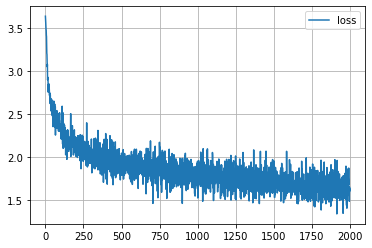

In [33]:
char_rnn = CharRNNModel()
optimizer = optim.Adam(char_rnn.parameters())
criterion = nn.CrossEntropyLoss()
train(char_rnn, optimizer, criterion)

In [39]:
MAX_LENGTH = 500
def generate_sample(char_rnn, seed_phrase=' hello', max_length=MAX_LENGTH, temperature=1.0):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs, 
        smaller temperature converges to the single most likely output.
        
    Be careful with the model output. This model waits logits (not probabilities/log-probabilities)
    of the next symbol.
    '''
    
    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor(x_sequence, dtype=torch.int64)
    hid_state = char_rnn.initial_state()
    
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        out, hid_state = char_rnn(x_sequence[i], hid_state)
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        out, hid_state = char_rnn(x_sequence[-1], hid_state)
        # Be really careful here with the model output
        p_next = F.softmax(out / temperature, dim=-1).data.numpy()[0]
        p_next = p_next.flatten()
        
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([next_ix], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=0)
        # print(x_sequence)
    
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()])

In [53]:
# examples of generated text.
print(generate_sample(char_rnn, seed_phrase="th", max_length=500, temperature=0.7))

thy hid speed to thou all i am all station the respite his even trilole, when my love;
  they defory love have then mayst thee deare:
    own thy present, weause in this which my love of my shall a will thou this not fair themeright;
  so me the with more of me hear i and tine had i she i head.
  and greate.

  cxxiv

  you hath concels me light the with my reather gent,
  the with thou to the thou doth there the all whee breack not doth my joftrr'd,
  maily's of thou that the some chack in my a


In [40]:
# An example of generated text.
# print(generate_text(length=500, temperature=0.2))

hide my will in thine?
  shall will in of the simend that in my sime the seave the seave the sorll the soren the sange the seall seares and and the fart the wirl the seall the songh whing that thou hall will thoun the soond beare the with that sare the simest me the fart the wirl the songre the with thy seart so for shat so for do the dost the sing the sing the sing the soond canding the sack and the farling the wirl of sore sich and that with the seare the seall so fort the with the past the wirl the simen the wirl the sores the sare


### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [111]:
class CharLSTMModel(nn.Module):
    def __init__(self, num_tokens=num_tokens, embedding_size=64, 
                 rnn_num_units=128):
        
        super(self.__class__, self).__init__()
        
        self.num_units = rnn_num_units
        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.lstm = nn.LSTM(input_size=embedding_size, hidden_size=rnn_num_units, batch_first=True)
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)
    
    def forward(self, x, h_state):
        x_emb = self.embedding(x.view(1, -1))
        h_seq, h_next = self.lstm(x_emb.view(1, 1, -1), h_state)
        logits = self.hid_to_logits(h_seq.view(1, -1))
        return logits, h_next
    
    def initial_state(self):
        """ return rnn state before it processes first input (aka h0) """
        return (Variable(torch.zeros(1, 1, self.num_units)), Variable(torch.zeros(1, 1, self.num_units)))

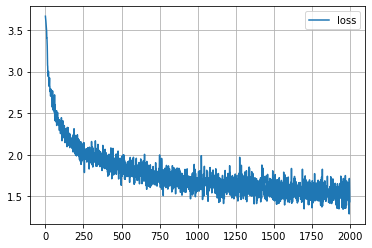

In [113]:
char_lstm = CharLSTMModel()
optimizer = optim.Adam(char_lstm.parameters())
criterion = nn.CrossEntropyLoss()
train(char_lstm, optimizer, criterion, batch_size=500, num_epochs=2000)

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [114]:
# Text generation with different temperature values here
# examples of generated text.
temperatures = [0.1, 0.2, 0.5, 1.0, 2.0]
for T in temperatures:
    print()
    print('Temperature:', T)
    print(generate_sample(char_lstm, seed_phrase=" ", max_length=500, temperature=T))


Temperature: 0.1
 shall the stand,
  that i have the will the seep the stand the seem the stand,
    and the will the sweet the sumble so the will,
  and the stand the stand the sweet the stant the seep the seep the seep in the seep in the stand,
    that i all the stand the seep the seep the stand the seep the stand,
  that the will the state the stand the will the seep in the seep the stance the stand,
  and the stand the stand the start the will the stand,
  and the will the seep the will the stand the self t

Temperature: 0.2
 shall my seep in the stant,
    the stain the stand the stant the sweet the stand,
  and i will with the will the fore the seep in the will,
  that the will the summer so the to the beauty of the self the seep the seep the seep is the seeming,
    the self i love the will the seep the speather's beauty's beauty of the shall will with the will,
  the will the world the stant with the stand the tould be the beauty of the praise,
    the wast the state the seen


- Как видно из приведенных выше графиков функция потерь после 2_000 эпох обучения для RNN и LSTM практически не отличаются.

- Температура отражает меру случайности при генерации текста, чем больше температура тем более случайный характер приобретает выбор следующей буквы. 

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [115]:
# Saving and loading code here

filename = "poem_lstm_model"
torch.save(char_lstm, filename)
model = torch.load(filename)
model.eval()
print(generate_sample(model, seed_phrase=" ", max_length=500, temperature=0.5))

 seep thy stride,
    when i my can mine eye prive,
  the blind the rease that where a and show i doth being manse, and in the beauty be of the beauty doth speed in heart,
  and thy forther that the some and the worst the true with thou add,
  and thee, the self to my mind of my beauty with the stank,
  my love a thou wilt the for my star in the love,
  that i for shall of fread you show not thy grease the speath;
    the in thou such which that wo thy summer i to shall fail will,
    thy seain 


### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)